In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
from functools import partial
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
from candlesticks import candlesticks
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
multi_periods = [5, 10, 20, 40, 80, 160]
#multi_periods = [5, 7, 10, 12, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 160, 320, 640] 
#multi_periods = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 60, 80, 100, 120, 140, 160] 
roc_periods = [5, 10]
vol_lookback = 200
smooth = int(np.ceil(periods/4))
atr_periods = 80

In [3]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
contract = contract.loc['20190101': '20191231']

In [4]:
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

9915.49165665634

In [5]:
vol_candles = group_by_volume(contract, avg_vol)

In [6]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [7]:
def ema(data, periods):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    up = (data.ema_fast > data.ema_slow) * 1
    down = (data.ema_fast < data.ema_slow) * 1
    return up - down

In [8]:
def breakout(data, periods):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).rename(periods, inplace=True)

In [9]:
def diff(data, periods):
    up = (data.close.diff(periods) > 0) * 1
    down = (data.close.diff(periods) < 0) * 1
    return (up - down).rename(periods, inplace=True)

In [10]:
def acc(data, periods):
    up = (data.close.pct_change(periods).pct_change(periods) > 0) * 1
    down = (data.close.pct_change(periods).pct_change(periods) < 0) * 1
    return (up - down).rename(periods, inplace=True)

In [11]:
def vol(data, vol_lookback):
    data = data.copy()
    data['returns'] = data['close'].pct_change()
    data['vol_returns'] = data['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
    data['vol_price'] = data['vol_returns'] * data['close']
    return data['vol_price']

In [12]:
vols = vol(data, vol_lookback)

In [13]:
def combine(data, multi_periods, funcs):
    result = pd.DataFrame()
    for func in funcs:
        result[func.__name__] = pd.DataFrame([func(data, p) for p in multi_periods]).T.sum(axis=1)
    return result

In [14]:
forecasts = pd.DataFrame([breakout(data, p) for p in multi_periods]).T

In [15]:
forecasts

,5,10,20,40,80,160
label,,,,,,
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,-1,0,0,0,0,0
...,...,...,...,...,...,...
7439,1,0,0,0,0,0
7440,1,0,0,0,0,0
7441,1,1,0,0,0,0


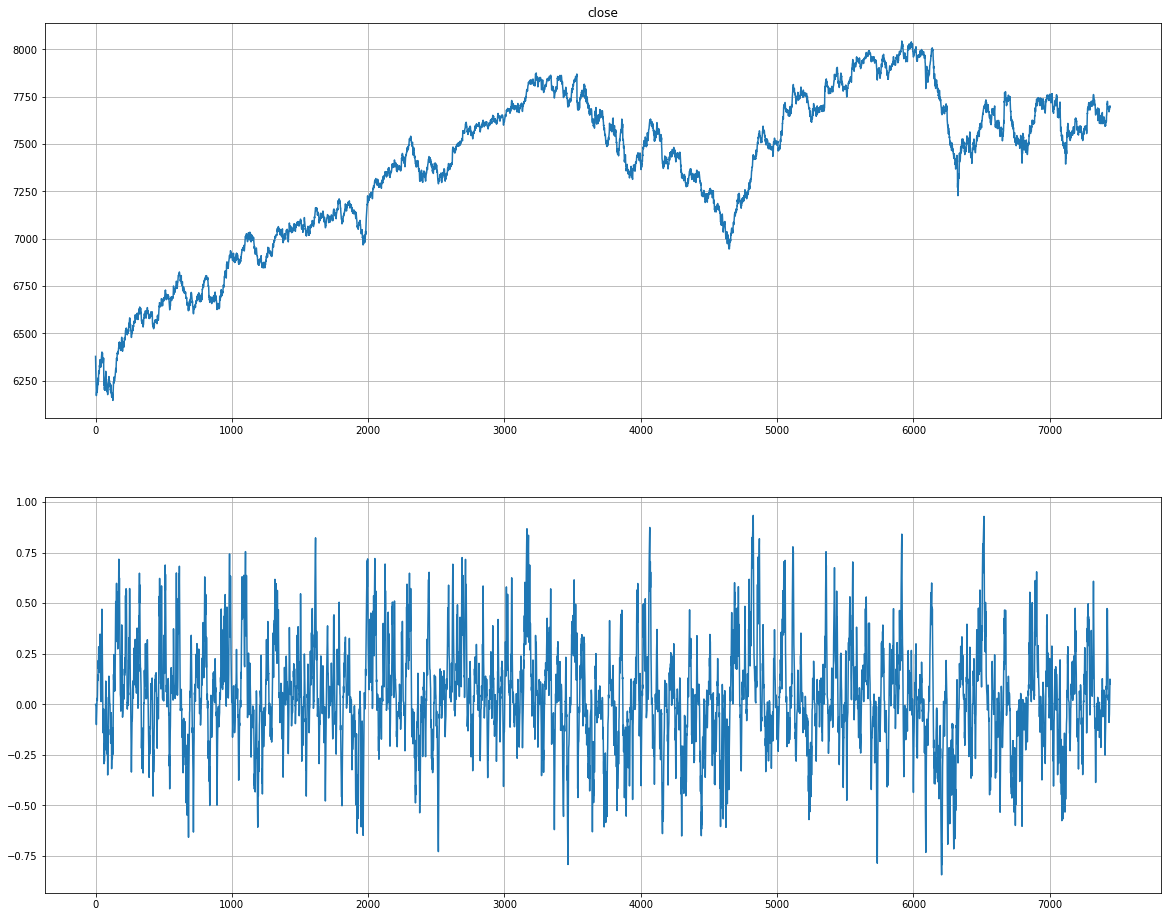

In [16]:
plot(data.close, forecasts.mean(axis=1).ewm(span=10).mean())

In [17]:
combined_forecast = forecasts.mean(axis=1).ewm(span=10).mean().rename('combined')
combined_forecast = combined_forecast*20

In [18]:
combined_forecast.abs().mean(), combined_forecast.abs().std()

(3.7559693568556645, 3.346220379754668)

In [19]:
#forecasts = (combine(data, multi_periods, [breakout])*multiplier).clip(lower=-20, upper=20)
#forecasts['diff'] = pd.DataFrame([diff(data, p) for p in roc_periods]).T.mean(axis=1)
#forecasts['combined'] = forecasts.sum(axis=1).ewm(span=50).mean()

In [20]:
data = data.join(combined_forecast)
data = data.iloc[200:]

In [21]:
#plot(data[['close',  'ema','combined']])

In [22]:
output = data.set_index('date')[['open','combined']]

In [23]:
out = summary(output.open, output.combined, slip=1.5)

In [24]:
out.stats

,0,3,5,6,7,10,15,17
Annual return,0.182409,0.132452,0.0860013,0.0369347,-0.0394137,-0.00746076,0.0102761,0.000338255
Cumulative returns,0.12265,0.0896812,0.0586198,0.0253591,-0.0273831,-0.00515745,0.00708419,0.000233545
Annual volatility,0.158717,0.124283,0.0907624,0.0763318,0.0680069,0.0371069,0.0161409,0.00408867
Sharpe ratio,1.13486,1.06272,0.954181,0.513208,-0.557295,-0.183415,0.641417,0.0847474
Calmar ratio,2.0405,2.14851,1.86788,0.857441,-0.636649,-0.269584,1.18931,0.14729
Stability,0.481531,0.741378,0.826122,0.643858,0.0230628,0.135738,0.575051,0.00561488
Max drawdown,-0.0893941,-0.0616485,-0.0460421,-0.0430755,-0.061908,-0.0276751,-0.00864043,-0.00229652
Omega ratio,1.21022,1.21037,1.19463,1.10887,0.887951,0.954441,1.47161,1.09993
Sortino ratio,1.74165,1.70874,1.53127,0.745852,-0.746502,-0.309273,1.19363,0.135103
Skew,0.0374345,0.346929,0.402293,-0.651306,-1.29738,1.75909,4.1537,2.93731


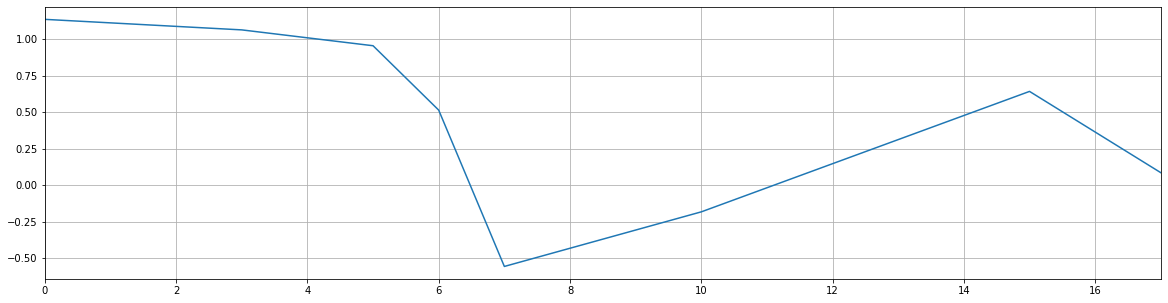

In [25]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

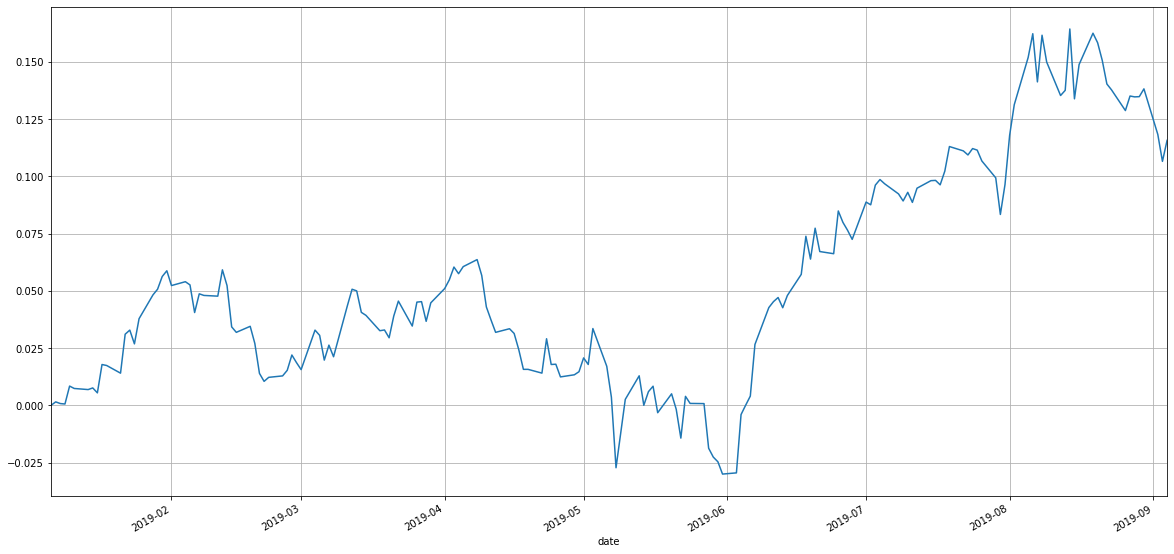

In [26]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);